In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json
from utils.transformations import min_max_normalization, inverse_min_max_normalization, transform_to_sparse, inverse_transform_to_sparse
import warnings
warnings.filterwarnings('ignore', category=UserWarning) #Ignore sklearn "RF fitted with FeatureNames"

train_dataset = pd.read_csv("../data/adult.csv")
dataset_name = 'adult'
instance_to_explain_index = 9090

with open('../data/adult_constraints.json', 'r') as f:
    constr = json.load(f)

train_dataset = train_dataset[constr['features_order_nonsplit']]
train_dataset.columns

Index(['hours.per.week', 'age', 'capital.loss', 'education.num',
       'capital.gain', 'workclass', 'marital.status', 'occupation', 'race',
       'sex', 'native.country', 'income'],
      dtype='object')

In [2]:
query_instance = train_dataset.drop(columns="income")[instance_to_explain_index:instance_to_explain_index+1]

all_counterfactuals = pd.DataFrame(columns=train_dataset.columns.tolist() + ['explainer'])

In [3]:
# Transform dataset to sparse
train_dataset_sparse = transform_to_sparse(
    _df=train_dataset.drop(columns="income"),
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Min-max normalization
train_dataset_sparse_normalized = min_max_normalization(
    _df=train_dataset_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

query_instance_sparse_normalized = train_dataset_sparse_normalized[instance_to_explain_index:instance_to_explain_index+1]

In [4]:
query_instance

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country
9090,40,39,0,9,0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States


DICE

In [5]:
from dice import DiceModel

dice_model = DiceModel(
    train_dataset=train_dataset,
    continuous_features=constr['continuous_features_nonsplit'],
    categorical_features=constr['categorical_features_nonsplit'],
    target=constr['target_feature'],
    model_path='../models/adult_RF.pkl',
    backend='sklearn',
    # model_path='../models/adult_NN/',
    # backend='TF2',
    func='ohe-min-max',
)

dice_counterfactuals_df = dice_model.generate_counterfactuals(
    query_instance=query_instance,
    total_CFs=20,
    desired_class='opposite',
    features_to_vary=constr['actionable_features'],
    permitted_range=constr['feature_ranges'],
)

dice_counterfactuals_df['explainer'] = 'dice'
all_counterfactuals = pd.concat([all_counterfactuals, dice_counterfactuals_df], ignore_index=True)

100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


In [6]:
all_counterfactuals.head(8)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,2.0,39.0,0.0,1.0,0.0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States,1,dice
1,5.0,39.0,0.0,7.0,0.0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States,1,dice
2,2.0,39.0,0.0,9.0,0.0,Self-emp-inc,Married-civ-spouse,Transport-moving,White,Male,United-States,1,dice
3,4.0,39.0,0.0,9.0,0.0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States,1,dice
4,5.0,39.0,0.0,9.0,0.0,?,Married-civ-spouse,Exec-managerial,White,Male,United-States,1,dice
5,5.0,39.0,0.0,9.0,0.0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States,1,dice
6,3.0,39.0,3982.0,9.0,0.0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States,1,dice
7,3.0,39.0,0.0,9.0,21212.0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States,1,dice


CFEC

In [7]:
from cfec_ece import CfecEceModel 
import tensorflow as tf

train_dataset_sparse_normalized_subsample = train_dataset_sparse_normalized.sample(frac=1.0)

cfec_model = CfecEceModel(
    train_data_normalized=train_dataset_sparse_normalized_subsample,
    constraints_dictionary=constr,
    # model_path='../models/adult_NN/',
    # model_backend='tensorflow',
    #fimap_load_s_g_full_id=f'adult_tensorflow|2023-01-17',
    #fimap_save_s_q_prefix='adult_tensorflow',
    model_path='../models/adult_RF.pkl',
    model_backend='sklearn',
    fimap_load_s_g_full_id=f'adult_sklearn|2023-01-17',
    #fimap_save_s_q_prefix='adult_sklearn'
    )

Constraints:  [Freeze(columns=['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White']), Freeze(columns=['sex_Female', 'sex_Male']), Freeze(columns=['native.country_?', 'native.country_Cambodia', 'native.country_Canada', 'native.country_China', 'native.country_Columbia', 'native.country_Cuba', 'native.country_Dominican-Republic', 'native.country_Ecuador', 'native.country_El-Salvador', 'native.country_England', 'native.country_France', 'native.country_Germany', 'native.country_Greece', 'native.country_Guatemala', 'native.country_Haiti', 'native.country_Holand-Netherlands', 'native.country_Honduras', 'native.country_Hong', 'native.country_Hungary', 'native.country_India', 'native.country_Iran', 'native.country_Ireland', 'native.country_Italy', 'native.country_Jamaica', 'native.country_Japan', 'native.country_Laos', 'native.country_Mexico', 'native.country_Nicaragua', 'native.country_Outlying-US(Guam-USVI-etc)', 'native.country_Peru', 'native.countr

In [8]:
cfec_counterfactuals_raw, list_cfs_explainers = cfec_model.generate_counterfactuals(query_instance=query_instance_sparse_normalized.iloc[0])
cfec_counterfactuals_raw

BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001BEE5657610> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001BEE7CC1210> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001BEE7F51180> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001BEE8423BE0> generated 1 counterfactuals
BCE <modules.CFEC.cfec.explainers._fimap.Fimap object at 0x000001BEE85BA1D0> generated 1 counterfactuals
1/1 [==============================] - 0s 20ms/step
BCE <modules.CFEC.cfec.explainers._cadex.Cadex object at 0x000001BEE5657550> found no countefactuals
1/1 [==============================] - 0s 21ms/step
BCE <modules.CFEC.cfec.explainers._cadex.Cadex object at 0x000001BEE5657700> found no countefactuals
1/1 [==============================] - 0s 20ms/step
BCE <modules.CFEC.cfec.explainers._cadex.Cadex object at 0x000001BEE5657790> found no countefactuals
1/1 [===========

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,-0.221934,-0.022777,0.247348,-0.065278,-0.614719,0.459547,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
1,-0.210958,0.001852,0.000000,-0.060477,-0.593282,0.466547,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
2,-0.209395,-0.026488,0.000000,-0.058336,-0.584407,0.422183,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
3,-0.208119,-0.015755,0.000000,-0.058308,0.000000,0.424167,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
4,-0.171327,-0.059769,0.000000,-0.030805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
5,-0.055648,0.368641,0.072542,0.296661,0.045009,0.149103,0.029483,0.064279,0.000215,0.697030,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11
6,-0.049509,0.375984,0.067137,0.309235,0.044663,0.149787,0.029483,0.064279,0.000215,0.697030,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11
7,0.072511,0.361564,0.035799,0.430107,0.026899,0.079582,0.029483,0.064279,0.000215,0.697030,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11
8,0.160742,0.346301,0.023165,0.463392,0.018541,0.046580,0.029483,0.064279,0.000215,0.697030,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11
9,0.192282,0.337834,0.016578,0.473209,0.015173,0.038607,0.029483,0.064279,0.000215,1.156572,...,2.851869e-12,-5.311182e-11,-9.715559e-12,-1.571294e-11,9.338692e-12,-1.077733e-11,6.132937e-12,1.0,-4.705550e-11,-1.123570e-11


In [9]:
# Do not allow for negative values
cfec_counterfactuals_raw[cfec_counterfactuals_raw < 0] = 0

# Inverse min-max normalization
cfec_counterfactuals = inverse_min_max_normalization(
    _df=cfec_counterfactuals_raw,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
cfec_counterfactuals = inverse_transform_to_sparse(
    sparse_df=cfec_counterfactuals,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')


In [10]:
list_cfs_explainers = list(map(lambda x: 'Cadex' if 'Cadex' in x else 'Fimap', list_cfs_explainers))
cfec_counterfactuals['explainer'] = list_cfs_explainers
all_counterfactuals = pd.concat([all_counterfactuals, cfec_counterfactuals], ignore_index=True)
cfec_counterfactuals

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,explainer
0,1,17,1077,1,0,Self-emp-inc,Separated,Other-service,White,Male,United-States,Cadex
1,1,17,0,1,0,Self-emp-inc,Separated,Other-service,White,Male,United-States,Cadex
2,1,17,0,1,0,Self-emp-inc,Never-married,Other-service,White,Male,United-States,Cadex
3,1,17,0,1,0,Self-emp-inc,Never-married,Other-service,White,Male,United-States,Cadex
4,1,17,0,1,0,Self-emp-inc,Never-married,Other-service,White,Male,United-States,Cadex
5,1,43,315,5,4500,Private,Married-civ-spouse,Exec-managerial,White,Male,United-States,Fimap
6,1,44,292,5,4466,Private,Married-civ-spouse,Exec-managerial,White,Male,United-States,Fimap
7,8,43,155,7,2689,Private,Married-civ-spouse,Exec-managerial,White,Male,United-States,Fimap
8,16,42,100,7,1854,Private,Married-civ-spouse,Exec-managerial,White,Male,United-States,Fimap
9,19,41,72,8,1517,Private,Married-civ-spouse,Exec-managerial,White,Male,United-States,Fimap


WACHTER

In [11]:
from alibi_impl import AlibiWachter

model = AlibiWachter('../models/adult_RF.pkl', 'sklearn', query_instance_sparse_normalized.shape)
#model = AlibiWachter('../models/adult_NN/', 'tensorflow', query_instance_sparse_normalized.shape)
explanation = model.generate_counterfactuals(query_instance_sparse_normalized)

c:\ProgramData\Anaconda3\envs\cf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No appropriate lambda range found, try decreasing lam_init


In [12]:
wachter_counterfactuals = []
for key, lst in explanation['data']['all'].items():
    if lst:
        for cf in lst:
            wachter_counterfactuals.append(cf['X'])

wachter_counterfactuals = np.array(wachter_counterfactuals).reshape(-1, query_instance_sparse_normalized.shape[1])

wachter_counterfactuals_df = pd.DataFrame(wachter_counterfactuals, columns=constr['features_order_after_split'])

# Inverse min-max normalization
wachter_counterfactuals_df = inverse_min_max_normalization(
    _df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Inverse transform to sparse
wachter_counterfactuals_df = inverse_transform_to_sparse(
    sparse_df=wachter_counterfactuals_df,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

wachter_counterfactuals_df['explainer'] = 'wachter'

# Reduce number of Wachter counterfactuals because they are almost the same
sampled_wachter_cfs = wachter_counterfactuals_df.sample(40)

all_counterfactuals = pd.concat([all_counterfactuals, sampled_wachter_cfs], ignore_index=True)

wachter_counterfactuals_df.head(5)

C:\Users\ignacy\AppData\Local\Temp\ipykernel_7244\1253476118.py:2: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  for key, lst in explanation['data']['all'].items():
d:\Research\ecemosp\src\utils\transformations.py:67: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dense_df[feature] = sparse_df[split_columns].idxmax(axis=1).str.replace(feature + '_', '')


AttributeError: Can only use .str accessor with string values!

In [ ]:
wachter_counterfactuals_df.shape

CFPROTO

In [13]:
# from alibi.explainers import CounterfactualProto

# import pickle
# with open('../models/adult_RF.pkl', 'rb') as f:
#     model = pickle.load(f)
# predict_fnct = lambda x: model.predict(x)


In [14]:
# cat_vars_ord = {}
# for i, cat in enumerate(constr['categorical_features_nonsplit']):
#     start_index = np.argwhere(cat == train_dataset.columns.to_numpy())[0][0]
#     unique = len(np.unique(train_dataset[cat]))
#     cat_vars_ord[start_index] = unique
# print(cat_vars_ord)

In [15]:
# cfProto = CounterfactualProto(predict_fnct,
#                          query_instance_sparse_normalized.shape,
#                          cat_vars=cat_vars_ord,
#                          ohe=True,  # OHE flag
#                          max_iterations=500,
#                          beta=0.01,
#                          feature_range=(0.0, 1.0),
#                          use_kdtree=True,
#                          theta= 10.,
#                          c_init=1.0,
#                          c_steps=5,
#                         )
# cfProto.fit(train_dataset_sparse_normalized.to_numpy(), d_type='abdm', trustscore_kwargs=None)
# explanation = cfProto.explain(query_instance_sparse_normalized.to_numpy())

VISUALIZATION

In [16]:
from visualization_helpers import get_scores
from visualization_helpers import remove_duplicates

all_counterfactuals = remove_duplicates(all_counterfactuals)
print('Counterfactuals: ', all_counterfactuals.shape)

# Transform counterfactuals to sparse
counterfactuals_sparse = transform_to_sparse(
    _df=all_counterfactuals,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize counterfactuals
counterfactuals_sparse_normalized = min_max_normalization(
    _df=counterfactuals_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)


# Transform query instance to sparse
query_instance_sparse = transform_to_sparse(
    _df=query_instance,
    original_df=train_dataset.drop(columns="income"),
    categorical_features=constr['categorical_features_nonsplit'],
    continuous_features=constr['continuous_features_nonsplit']
)

# Normalize query instance sparse
query_instance_sparse_normalized = min_max_normalization(
    _df=query_instance_sparse,
    original_df=train_dataset.drop(columns="income"),
    continuous_features=constr['continuous_features_nonsplit']
)

# Mask non actionable features
mask_indices = [1 if any([act in x for act in constr['actionable_features']]) else 0 for x in constr['features_order_after_split']]

Counterfactuals:  (27, 13)


In [17]:
from visualization_helpers import filter_non_valid
from visualization_helpers import filter_non_actionable
import pickle

# SKLEARN
with open('../models/adult_RF.pkl', 'rb') as f:
    model = pickle.load(f)

# TENSORFLOW
# model = tf.keras.models.load_model('../models/adult_NN/')

predict_fn = lambda x: model.predict(x)

valid_counterfactuals_sparse_normalized = filter_non_valid(predict_fn, query_instance_sparse_normalized, counterfactuals_sparse_normalized)
valid_counterfactuals_sparse_normalized.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')

In [18]:
#Filter not feasible (data is min-max normalized, so values shouldn't be less than zero)
# not_feasible = np.where(np.sum(counterfactuals_sparse_normalized < 0, axis=1) > 0)[0]
not_feasible = []

indices_to_keep = list(filter(lambda x: x not in not_feasible, valid_counterfactuals_sparse_normalized.index.tolist()))
valid_counterfactuals_sparse_normalized = counterfactuals_sparse_normalized.iloc[indices_to_keep]
print(indices_to_keep)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [19]:
valid_counterfactuals_sparse_normalized.head(5)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,0.010204,0.30137,0.0,0.000000,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.040816,0.30137,0.0,0.400000,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.010204,0.30137,0.0,0.533333,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.030612,0.30137,0.0,0.533333,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.040816,0.30137,0.0,0.533333,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
valid_counterfactuals = all_counterfactuals.iloc[indices_to_keep]
valid_counterfactuals.reset_index(drop=True, inplace=True)
valid_counterfactuals = filter_non_actionable(valid_counterfactuals, query_instance, constr['non_actionable_features'])
valid_counterfactuals_sparse_normalized = valid_counterfactuals_sparse_normalized.iloc[valid_counterfactuals.index.tolist()]
valid_counterfactuals_sparse_normalized.reset_index(drop=True, inplace=True)
valid_counterfactuals.reset_index(drop=True, inplace=True)
valid_counterfactuals.shape

(24, 3)
(1, 3)


(24, 13)

In [21]:
# add income column
valid_counterfactuals['income'] = np.argmax(predict_fn(valid_counterfactuals_sparse_normalized.to_numpy()[0:1]))
valid_counterfactuals.head(5)

,hours.per.week,age,capital.loss,education.num,capital.gain,workclass,marital.status,occupation,race,sex,native.country,income,explainer
0,2.0,39.0,0.0,1.0,0.0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States,0,dice
1,5.0,39.0,0.0,7.0,0.0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States,0,dice
2,2.0,39.0,0.0,9.0,0.0,Self-emp-inc,Married-civ-spouse,Transport-moving,White,Male,United-States,0,dice
3,4.0,39.0,0.0,9.0,0.0,Self-emp-inc,Married-civ-spouse,Exec-managerial,White,Male,United-States,0,dice
4,5.0,39.0,0.0,9.0,0.0,?,Married-civ-spouse,Exec-managerial,White,Male,United-States,0,dice


In [22]:
scores_df = get_scores(valid_counterfactuals_sparse_normalized.to_numpy(), query_instance_sparse_normalized, train_dataset_sparse_normalized, train_dataset['income'], mask_indices)

In [23]:
scores_df['explainer'] = valid_counterfactuals['explainer']
scores_df.head(10)

,cf,proximity,features_changed,feasibility,actionability,preference_dcg,discriminative_power,dispreference_dcg,non_discriminative_power,explainer
0,"[0.01020408163265306, 0.3013698630136986, 0.0,...",0.921088,2,0.276665,True,0.266667,0.466667,0.457364,0.533333,dice
1,"[0.04081632653061224, 0.3013698630136986, 0.0,...",0.490476,2,0.106526,True,0.066667,0.500000,0.657364,0.500000,dice
2,"[0.01020408163265306, 0.3013698630136986, 0.0,...",2.387755,3,0.154986,True,0.000000,0.333333,0.724031,0.666667,dice
3,"[0.030612244897959183, 0.3013698630136986, 0.0...",0.367347,1,0.094475,True,0.000000,0.600000,0.724031,0.400000,dice
4,"[0.04081632653061224, 0.3013698630136986, 0.0,...",2.357143,3,2.005569,True,0.386853,0.100000,0.337178,0.900000,dice
5,"[0.04081632653061224, 0.3013698630136986, 0.0,...",0.357143,1,0.088748,True,0.000000,0.600000,0.724031,0.400000,dice
6,"[0.02040816326530612, 0.3013698630136986, 0.91...",1.291692,2,0.353848,True,0.576759,0.700000,0.147272,0.300000,dice
7,"[0.02040816326530612, 0.3013698630136986, 0.0,...",0.589673,2,0.133166,True,0.091356,0.666667,0.632675,0.333333,dice
8,"[0.01020408163265306, 0.3013698630136986, 0.0,...",0.387755,1,0.106553,True,0.000000,0.600000,0.724031,0.400000,dice
9,"[0.02040816326530612, 0.3013698630136986, 0.0,...",0.377551,1,0.100410,True,0.000000,0.600000,0.724031,0.400000,dice


In [24]:
import seaborn as sns

# We want to plot only subset of columns 
scores_to_plot = scores_df.drop(['cf', 'actionability', 'preference_dcg', 'discriminative_power'], axis=1)

# # Pairplot
# sns.pairplot(scores_to_plot, hue="explainer", diag_kind='kde')

In [25]:
if 'sklearn' in str(type(model)):
    explained_model = 'RF'
else:
    explained_model = 'NN'

For explainer: Fimap and metrics features_changed, proximity, paretos: 0 out of 2
For explainer: Cadex and metrics features_changed, proximity, paretos: 0 out of 3
For explainer: dice and metrics features_changed, proximity, paretos: 1 out of 19
For explainer: Fimap and metrics feasibility, proximity, paretos: 0 out of 2
For explainer: Cadex and metrics feasibility, proximity, paretos: 0 out of 3
For explainer: dice and metrics feasibility, proximity, paretos: 3 out of 19
For explainer: Fimap and metrics dispreference_dcg, proximity, paretos: 0 out of 2
For explainer: Cadex and metrics dispreference_dcg, proximity, paretos: 1 out of 3
For explainer: dice and metrics dispreference_dcg, proximity, paretos: 6 out of 19
For explainer: Fimap and metrics non_discriminative_power, proximity, paretos: 0 out of 2
For explainer: Cadex and metrics non_discriminative_power, proximity, paretos: 0 out of 3
For explainer: dice and metrics non_discriminative_power, proximity, paretos: 3 out of 19
For 

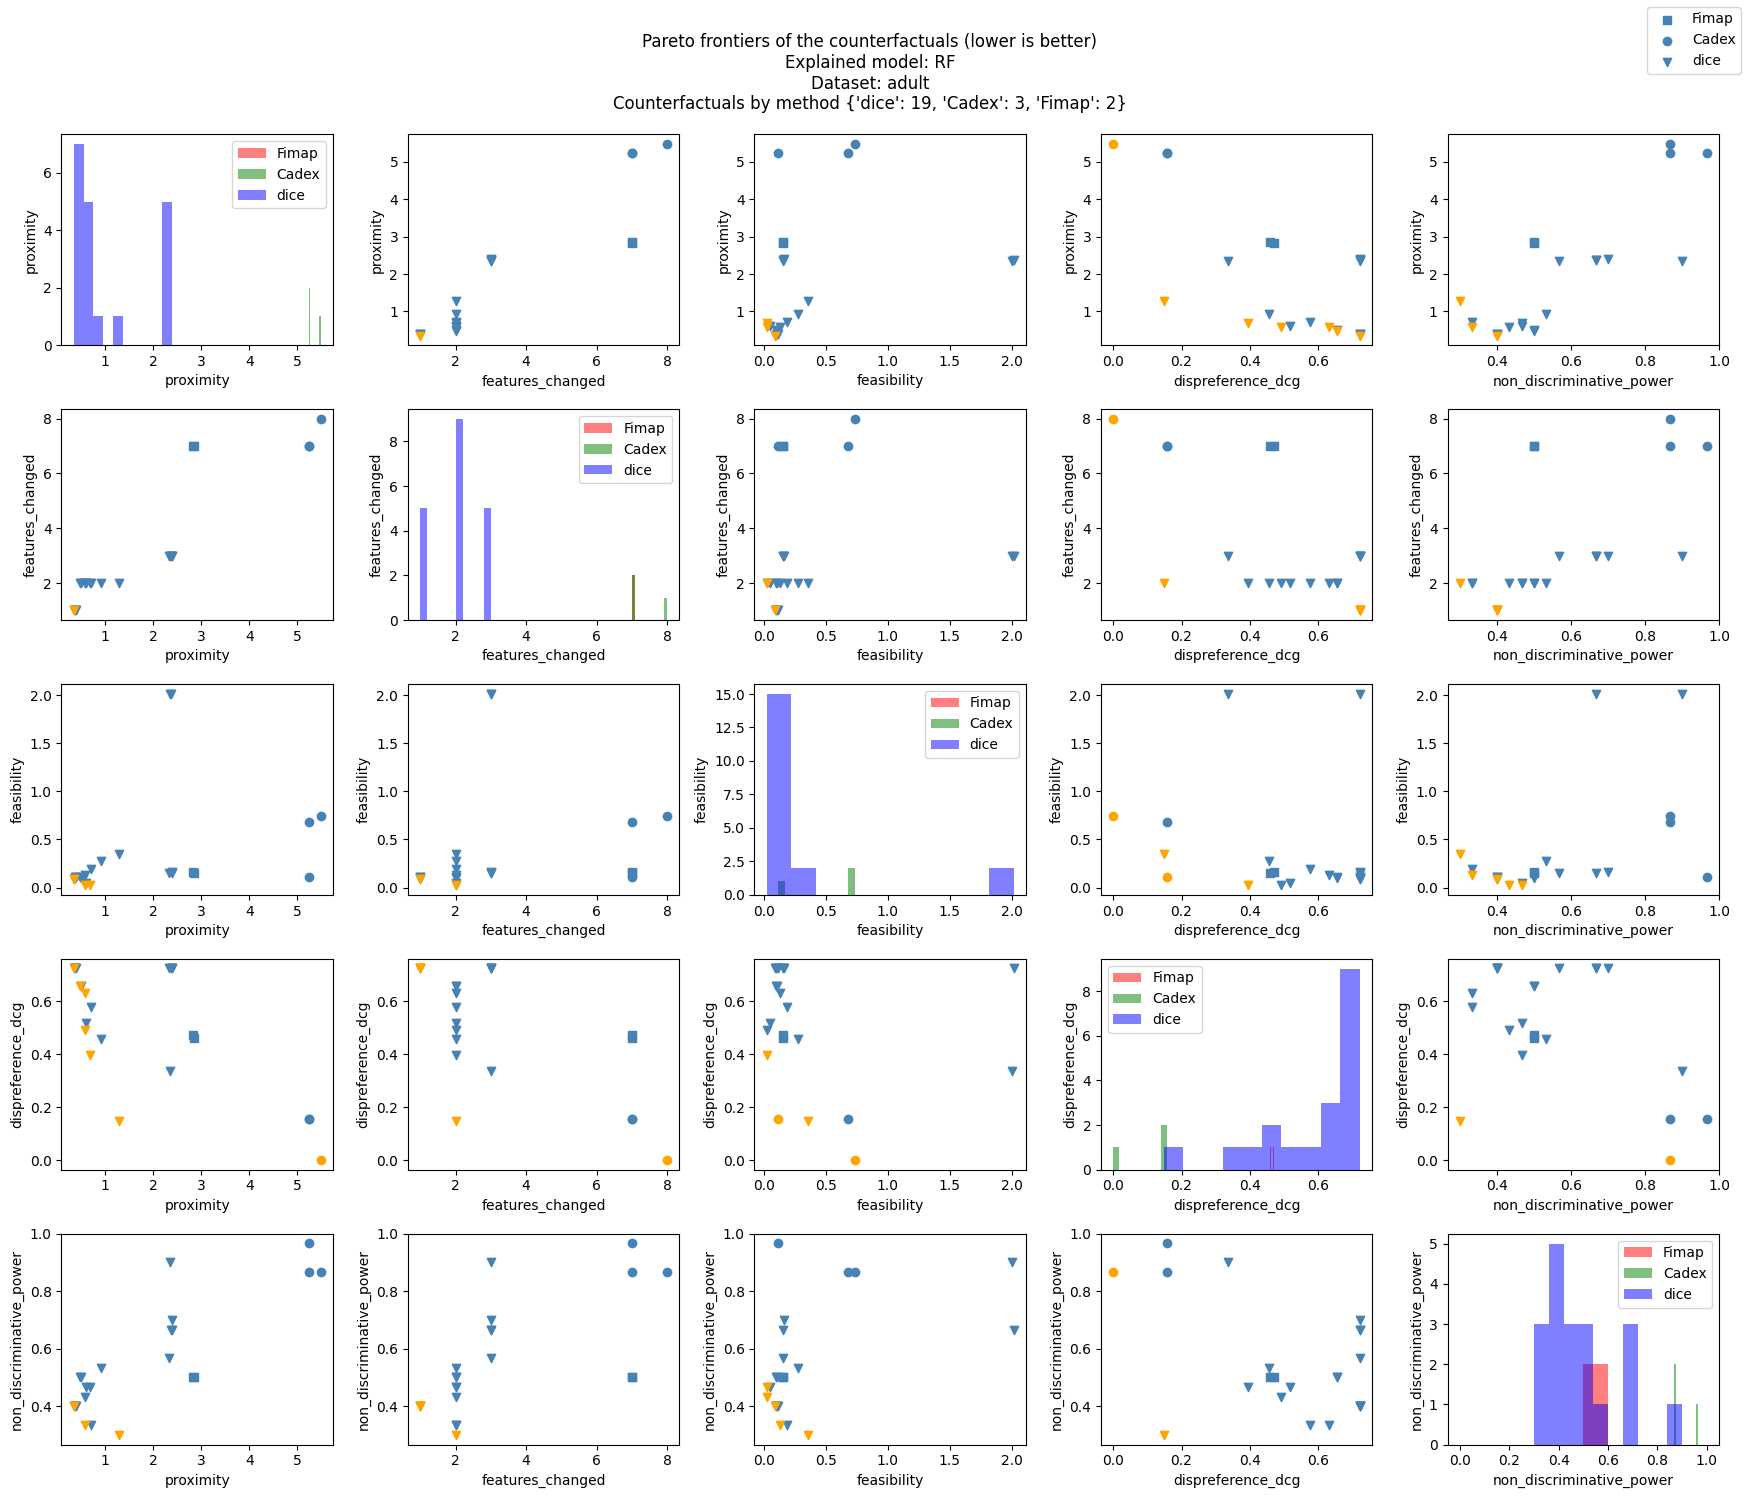

In [26]:
import matplotlib.pyplot as plt
from visualization_helpers import get_pareto_frontier_mask


metrics_to_plot = ['proximity', 'features_changed', 'feasibility', 'dispreference_dcg', 'non_discriminative_power']
n = len(metrics_to_plot)

fig, ax = plt.subplots(n, n, figsize=(3.5*n, 3*n))

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
markers = ['s', 'o', 'v', '+', 'x']
labels = []

ax = ax.flatten()

for plot_round in ['nonpareto', 'pareto']:
    for i, other_metric in enumerate(metrics_to_plot):
        for j, metric in enumerate(metrics_to_plot):

            all_x = scores_df[metric].to_numpy()
            all_y = scores_df[other_metric].to_numpy()
            to_check = np.array([all_x, all_y], dtype=np.float64).T
            all_pareto = get_pareto_frontier_mask(to_check)
            ax[i*n+j].grid()

            for k, explainer in enumerate(scores_df['explainer'].value_counts().sort_values(ascending=True).index.tolist()):

                mask = scores_df['explainer'] == explainer
                pareto = all_pareto[mask]

                x = scores_df[mask][metric].to_numpy()
                y = scores_df[mask][other_metric].to_numpy()
            
                if plot_round == 'nonpareto':
                    if i == j:
                        ax[i*n+j].hist(x, color=colors[k], label=explainer, alpha=0.5)
                        ax[i*n+j].legend()
                    else:
                        ax[i*n+j].scatter(x[~pareto], y[~pareto], color='steelblue', marker=markers[k], label=explainer)
                elif plot_round == 'pareto' and i!=j:
                    ax[i*n+j].scatter(x[pareto], y[pareto], color='orange', marker=markers[k])

                    if i < j:
                        print(f'For explainer: {explainer} and metrics {metric}, {other_metric}, paretos: {sum(pareto)} out of {len(pareto)}')
                        # print(f'{scores_df[scores_df["explainer"] == explainer][[metric, other_metric]][pareto]}')
            
            ax[i*n+j].set_xlabel(metric)
            ax[i*n+j].set_ylabel(other_metric)
    # plt.title('Proximity vs Dispreference DCG \n(Pareto front in orange). \nLower is better.')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

counts = scores_df['explainer'].value_counts()

plt.suptitle(f'Pareto frontiers of the counterfactuals (lower is better)\nExplained model: {explained_model}\nDataset: {dataset_name}\nCounterfactuals by method {counts.to_dict()}\n')
plt.tight_layout()
plt.savefig(f'../images/{dataset_name}/{explained_model}/{dataset_name}_pairplot_with_frontiers_{instance_to_explain_index}.png')
plt.show()

In [27]:
scores_df[['feasibility', 'features_changed']]

,feasibility,features_changed
0,0.276665,2
1,0.106526,2
2,0.154986,3
3,0.094475,1
4,2.005569,3
5,0.088748,1
6,0.353848,2
7,0.133166,2
8,0.106553,1
9,0.100410,1


In [28]:
metric = 'feasibility'
other_metric = 'features_changed'
all_x = scores_df[metric].to_numpy()
all_y = scores_df[other_metric].to_numpy()
to_check = np.array([all_x, all_y], dtype=np.float64).T
all_pareto = get_pareto_frontier_mask(to_check)
scores_df[[metric, other_metric, 'explainer']][all_pareto]

,feasibility,features_changed,explainer
5,0.088748,1,dice
16,0.024189,2,dice


In [29]:
scores_df['explainer']

0      dice
1      dice
2      dice
3      dice
4      dice
5      dice
6      dice
7      dice
8      dice
9      dice
10     dice
11     dice
12     dice
13     dice
14     dice
15     dice
16     dice
17     dice
18     dice
19    Cadex
20    Cadex
21    Cadex
22    Fimap
23    Fimap
Name: explainer, dtype: object